<a href="https://colab.research.google.com/github/menon92/DL-Sneak-Peek/blob/master/%E0%A6%9F%E0%A7%87%E0%A6%A8%E0%A7%8D%E0%A6%B8%E0%A6%B0%E0%A6%AB%E0%A7%8D%E0%A6%B2%E0%A7%8B_%E0%A7%A8_%E0%A7%A6_%E0%A6%93_%E0%A6%95%E0%A7%87%E0%A6%B0%E0%A6%BE%E0%A6%B8_%E0%A6%AA%E0%A6%B0%E0%A6%BF%E0%A6%9A%E0%A6%BF%E0%A6%A4%E0%A6%BF_%E0%A6%AA%E0%A6%B0%E0%A7%8D%E0%A6%AC_%E0%A7%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ইমেজ ডাটা - ৩য় পর্ব
`tf.data` ব্যাবহার করে ইমেজ ডাটা লোড করা । ইমেজ ডাটা লোড করার ক্ষেত্রে `keras.preprocessing` ব্যাবহার করা সুবিধাজনক কিন্তু এটার কিছু সমস্যা আছে ।  

- এটা `tf.data` থেকে সময় বেশি নেই । সময় কিরকম বেশি নেয় সটা আমরা নিচে দেখিয়েছি । 
- এটাতে প্রোগ্রামারের কন্ট্রোল তুলনামূলক ভাবে কম । 
- এটা টেন্সরফ্লোর সাথে পুরোপুরি ভাবে ইন্টিগ্রেটেড না । 

In [0]:
try:
  # %tensorflow_version এই কমান্ড কেবলমাত্র colab এ কাজ করে লোকাল নোটবুকে কাজ করবে না । 
  # এই জন্য try except ব্যাবহার করা হয়েছে । 
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# download data as before

DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

data_dir = tf.keras.utils.get_file(origin=DATASET_URL, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
print('Dataset directory:', data_dir)

228818944/228813984 [==============================] - 2s 0us/step
Dataset directory: /root/.keras/datasets/flower_photos


In [8]:
# extract class as before
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses'],
      dtype='<U10')

In [0]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

To load the files as a tf.data.Dataset first create a dataset of the file paths:
ডাটাসেটের ফাইলগুলোকে `tf.data.Dataset` আকারে লোড করার জন্য আমাদের `tf.data.Dataset` এর instance বানাতে হবে ।

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
# Let's print 5 data
for f in list_ds.take(5):
    print(type(f.numpy()), ' ', f.numpy())

<class 'bytes'>   b'/root/.keras/datasets/flower_photos/sunflowers/7820626738_3be6a52e4e_n.jpg'
<class 'bytes'>   b'/root/.keras/datasets/flower_photos/daisy/3084924076_4d5c5711af_m.jpg'
<class 'bytes'>   b'/root/.keras/datasets/flower_photos/tulips/8673412732_f8fd690ee4_n.jpg'
<class 'bytes'>   b'/root/.keras/datasets/flower_photos/dandelion/17147436650_c94ae24004_n.jpg'
<class 'bytes'>   b'/root/.keras/datasets/flower_photos/daisy/5885826924_38fdc6bcaa_n.jpg'


এখনে আমরা কিছু ফাংশন লিখব । `get_label` এই ফাংশনের কাজ এটাকে কোন ইমেজের ফুল পাথ দিলে সেখান থেকে ইমেজের লেবেল বের করে ।  

In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # print(parts)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [11]:
# test get_label method
file_path = b'/root/.keras/datasets/flower_photos/daisy/16482676953_5296227d40_n.jpg'
tmp_label = get_label(file_path).numpy()
print(tmp_label)

[False  True False False False]


`decode_img` এই ফাংশন কে `tf.io.read_file` দিয়ে ইমেজ ফাইল রিড করে পাঠায়া দিলে সে এটাকে `jpeg` তে ডিকোড করে । এবং শেষ মুল ইমেজ কে রিসাজ করে ফেলে । 

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [14]:
# test decode_img method
image = tf.io.read_file(file_path) # read image as string
image = decode_img(image)
image.shape

TensorShape([224, 224, 3])

`process_path` ফাংশন একটা ইমেজ পাথ কে প্রসেস করে `(img, label)` আকারে রিটার্ন করে ।  

In [0]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

`image, label` এই আকারে ডাটা বানানোর জন্য আমরা `Dataset.map` ব্যাবহার করব । একাধিক ইমেজ যাতে করে প্যারালালি লোড এবং প্রসেস করা যায় যায় এই জন্য আমরা `num_parallel_calls=AUTOTUNE)` ব্যাবহার করব । 

`tf.data.experimental.AUTOTUNE` এটা ডিফাইন করে আপনার কম্পিউটারে কাজ করার জন্য কয়টা প্রসেস ফাকা আছে । 

Image shape: (224, 224, 3)
Image label: [False False False  True False]


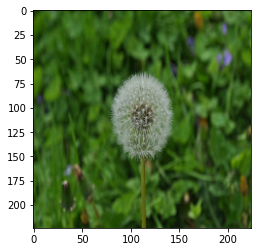

In [17]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in labeled_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Image label:", label.numpy())
    plt.imshow(image.numpy())
    plt.show()

এর পরের পর্বে আমরা `tf.data.Dataset` এবং `tf.keras.preprocessing.image.ImageDataGenerator` এই দুইটার সুবিধা অসুবিধা সম্পর্কে দেখব ।। 